In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [13]:
from __future__ import annotations

from pathlib import Path
from typing import Iterable, Union, Optional

import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET


# ----------------------------
# 1) Robust readers (incl. XML-as-.xls)
# ----------------------------
def _file_signature(path: Union[str, Path], n: int = 8) -> bytes:
    with Path(path).open("rb") as f:
        return f.read(n)

def _local(tag: str) -> str:
    return tag.split("}", 1)[1] if "}" in tag else tag

def _get_attr_endswith(elem: ET.Element, suffix: str) -> Optional[str]:
    for k, v in elem.attrib.items():
        if k.endswith(suffix):
            return v
    return None

def _read_excel_2003_xml(path: Union[str, Path], sheet_name: Union[int, str] = 0) -> pd.DataFrame:
    """
    Excel 2003 XML (SpreadsheetML) reader.
    Returns a raw DataFrame (strings/None), namespace-agnostic.
    """
    path = Path(path)
    tree = ET.parse(path)
    root = tree.getroot()

    worksheets = [e for e in root.iter() if _local(e.tag) == "Worksheet"]
    if not worksheets:
        raise ValueError(f"No Worksheet elements found in: {path.name}")

    def ws_name(ws: ET.Element) -> str:
        return (_get_attr_endswith(ws, "Name") or "").strip()

    def ws_data_count(ws: ET.Element) -> int:
        return sum(
            1 for e in ws.iter()
            if _local(e.tag) == "Data" and e.text and str(e.text).strip() != ""
        )

    # pick worksheet
    if isinstance(sheet_name, int):
        ws = worksheets[sheet_name]
    else:
        target = str(sheet_name).strip().lower()
        exact = [w for w in worksheets if ws_name(w).lower() == target]
        if exact:
            ws = exact[0]
        else:
            # fallback: most "Data" cells
            ws = max(worksheets, key=ws_data_count)

    table = next((e for e in ws.iter() if _local(e.tag) == "Table"), None)
    if table is None:
        raise ValueError(f"No Table element found in worksheet for: {path.name}")

    rows = [e for e in table if _local(e.tag) == "Row"]

    data_rows: list[list[Optional[str]]] = []
    max_cols = 0

    for r in rows:
        row_vals: list[Optional[str]] = []
        col_pos = 1  # SpreadsheetML ss:Index is 1-based

        cells = [e for e in r if _local(e.tag) == "Cell"]
        for c in cells:
            idx = _get_attr_endswith(c, "Index")
            if idx:
                target_col = int(idx)
                while col_pos < target_col:
                    row_vals.append(None)
                    col_pos += 1

            # Data may be nested; search within the cell
            d = next((e for e in c.iter() if _local(e.tag) == "Data"), None)
            val = d.text if d is not None else None
            if isinstance(val, str):
                val = val.strip()
            row_vals.append(val if val not in ("", None) else None)
            col_pos += 1

        max_cols = max(max_cols, len(row_vals))
        data_rows.append(row_vals)

    for rv in data_rows:
        if len(rv) < max_cols:
            rv.extend([None] * (max_cols - len(rv)))

    return pd.DataFrame(data_rows)

def _read_any_excel(path: Union[str, Path], sheet_name: Union[int, str] = 0) -> pd.DataFrame:
    p = Path(path)
    sig = _file_signature(p, 8)

    if sig.startswith(b"<?xml"):
        return _read_excel_2003_xml(p, sheet_name=sheet_name)

    if sig.startswith(b"PK\x03\x04"):
        return pd.read_excel(p, sheet_name=sheet_name, engine="openpyxl")

    if sig.startswith(b"\xD0\xCF\x11\xE0"):
        return pd.read_excel(p, sheet_name=sheet_name, engine="xlrd")

    # last fallback
    return pd.read_excel(p, sheet_name=sheet_name)


# ----------------------------
# 2) Parsing helpers (CET/CEST + € + decimal comma)
# ----------------------------
def _parse_price_eur(series: pd.Series) -> pd.Series:
    # If pandas already read it as numeric, do NOT string-clean it.
    if pd.api.types.is_numeric_dtype(series):
        return series.astype(float)

    s = series.astype(str).str.strip()

    # remove currency and whitespace
    s = s.str.replace("\u00A0", "", regex=False)   # NBSP
    s = s.str.replace("€", "", regex=False)
    s = s.str.replace("EUR", "", regex=False).str.strip()

    # keep only digits, comma, dot, minus
    s = s.str.replace(r"[^0-9,\.\-]+", "", regex=True)

    def _to_float(x: str) -> float:
        if x is None:
            return np.nan
        x = str(x).strip()
        if x == "" or x.lower() in {"nan", "none"}:
            return np.nan

        has_comma = "," in x
        has_dot = "." in x

        if has_comma and has_dot:
            # assume: '.' thousands, ',' decimal  ->  1.234,56 -> 1234.56
            x = x.replace(".", "").replace(",", ".")
        elif has_comma:
            # assume: ',' decimal -> 13,6 -> 13.6
            x = x.replace(",", ".")
        # else: only dot (or only digits) -> dot is decimal, keep as-is

        try:
            return float(x)
        except Exception:
            return np.nan

    return s.map(_to_float)

def _parse_timestamp_cet(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()

    # strip trailing timezone abbreviations in the cell text
    s = s.str.replace(r"\s+(CET|CEST)\s*$", "", regex=True)

    # parse
    return pd.to_datetime(s, errors="coerce")

def _format_eur_comma(x: float) -> str:
    if pd.isna(x):
        return ""
    s = f"{x:.2f}".rstrip("0").rstrip(".")   # 13.60 -> 13.6, 13.00 -> 13
    return s.replace(".", ",") + "€"

import xml.etree.ElementTree as ET


# ----------------------------
# 1) Robust readers (incl. XML-as-.xls)
# ----------------------------
def _file_signature(path: Union[str, Path], n: int = 8) -> bytes:
    with Path(path).open("rb") as f:
        return f.read(n)

def _local(tag: str) -> str:
    return tag.split("}", 1)[1] if "}" in tag else tag

def _get_attr_endswith(elem: ET.Element, suffix: str) -> Optional[str]:
    for k, v in elem.attrib.items():
        if k.endswith(suffix):
            return v
    return None

def _read_excel_2003_xml(path: Union[str, Path], sheet_name: Union[int, str] = 0) -> pd.DataFrame:
    """
    Excel 2003 XML (SpreadsheetML) reader.
    Returns a raw DataFrame (strings/None), namespace-agnostic.
    """
    path = Path(path)
    tree = ET.parse(path)
    root = tree.getroot()

    worksheets = [e for e in root.iter() if _local(e.tag) == "Worksheet"]
    if not worksheets:
        raise ValueError(f"No Worksheet elements found in: {path.name}")

    def ws_name(ws: ET.Element) -> str:
        return (_get_attr_endswith(ws, "Name") or "").strip()

    def ws_data_count(ws: ET.Element) -> int:
        return sum(
            1 for e in ws.iter()
            if _local(e.tag) == "Data" and e.text and str(e.text).strip() != ""
        )

    # pick worksheet
    if isinstance(sheet_name, int):
        ws = worksheets[sheet_name]
    else:
        target = str(sheet_name).strip().lower()
        exact = [w for w in worksheets if ws_name(w).lower() == target]
        if exact:
            ws = exact[0]
        else:
            # fallback: most "Data" cells
            ws = max(worksheets, key=ws_data_count)

    table = next((e for e in ws.iter() if _local(e.tag) == "Table"), None)
    if table is None:
        raise ValueError(f"No Table element found in worksheet for: {path.name}")

    rows = [e for e in table if _local(e.tag) == "Row"]

    data_rows: list[list[Optional[str]]] = []
    max_cols = 0

    for r in rows:
        row_vals: list[Optional[str]] = []
        col_pos = 1  # SpreadsheetML ss:Index is 1-based

        cells = [e for e in r if _local(e.tag) == "Cell"]
        for c in cells:
            idx = _get_attr_endswith(c, "Index")
            if idx:
                target_col = int(idx)
                while col_pos < target_col:
                    row_vals.append(None)
                    col_pos += 1

            # Data may be nested; search within the cell
            d = next((e for e in c.iter() if _local(e.tag) == "Data"), None)
            val = d.text if d is not None else None
            if isinstance(val, str):
                val = val.strip()
            row_vals.append(val if val not in ("", None) else None)
            col_pos += 1

        max_cols = max(max_cols, len(row_vals))
        data_rows.append(row_vals)

    for rv in data_rows:
        if len(rv) < max_cols:
            rv.extend([None] * (max_cols - len(rv)))

    return pd.DataFrame(data_rows)

def _read_any_excel(path: Union[str, Path], sheet_name: Union[int, str] = 0) -> pd.DataFrame:
    p = Path(path)
    sig = _file_signature(p, 8)

    if sig.startswith(b"<?xml"):
        return _read_excel_2003_xml(p, sheet_name=sheet_name)

    if sig.startswith(b"PK\x03\x04"):
        return pd.read_excel(p, sheet_name=sheet_name, engine="openpyxl")

    if sig.startswith(b"\xD0\xCF\x11\xE0"):
        return pd.read_excel(p, sheet_name=sheet_name, engine="xlrd")

    # last fallback
    return pd.read_excel(p, sheet_name=sheet_name)


# ----------------------------
# 2) Parsing helpers (CET/CEST + € + decimal comma)
# ----------------------------
def _parse_price_eur(series: pd.Series) -> pd.Series:
    # If pandas already read it as numeric, do NOT string-clean it.
    if pd.api.types.is_numeric_dtype(series):
        return series.astype(float)

    s = series.astype(str).str.strip()

    # remove currency and whitespace
    s = s.str.replace("\u00A0", "", regex=False)   # NBSP
    s = s.str.replace("€", "", regex=False)
    s = s.str.replace("EUR", "", regex=False).str.strip()

    # keep only digits, comma, dot, minus
    s = s.str.replace(r"[^0-9,\.\-]+", "", regex=True)

    def _to_float(x: str) -> float:
        if x is None:
            return np.nan
        x = str(x).strip()
        if x == "" or x.lower() in {"nan", "none"}:
            return np.nan

        has_comma = "," in x
        has_dot = "." in x

        if has_comma and has_dot:
            # assume: '.' thousands, ',' decimal  ->  1.234,56 -> 1234.56
            x = x.replace(".", "").replace(",", ".")
        elif has_comma:
            # assume: ',' decimal -> 13,6 -> 13.6
            x = x.replace(",", ".")
        # else: only dot (or only digits) -> dot is decimal, keep as-is

        try:
            return float(x)
        except Exception:
            return np.nan

    return s.map(_to_float)

def _parse_timestamp_cet(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()

    # strip trailing timezone abbreviations in the cell text
    s = s.str.replace(r"\s+(CET|CEST)\s*$", "", regex=True)

    # parse
    return pd.to_datetime(s, errors="coerce")

def _format_eur_comma(x: float) -> str:
    if pd.isna(x):
        return ""
    s = f"{x:.2f}".rstrip("0").rstrip(".")   # 13.60 -> 13.6, 13.00 -> 13
    return s.replace(".", ",") + "€"


# ----------------------------
# 3) Header-based extraction (find “Timestamp” row/col)
# ----------------------------
def _find_header(raw: pd.DataFrame) -> tuple[int, int, int]:
    """
    Returns: (header_row_idx, timestamp_col_idx, price_col_idx)
    Searches for a cell containing 'timestamp' and a cell containing 'price' in the same row.
    """
    arr = raw.to_numpy(dtype=object)

    def is_ts(x) -> bool:
        return isinstance(x, str) and "timestamp" in x.strip().lower()

    def is_price(x) -> bool:
        if not isinstance(x, str):
            return False
        t = x.strip().lower()
        return ("price" in t) or ("€/mwh" in t) or ("eur/mwh" in t)

    ts_mask = np.vectorize(is_ts, otypes=[bool])(arr)
    ts_pos = np.argwhere(ts_mask)
    if ts_pos.size == 0:
        raise ValueError("Could not find a header cell containing 'Timestamp'.")

    # pick first occurrence of Timestamp
    r0, c_ts = ts_pos[0]

    # find price header in same row
    row = arr[r0, :]
    price_candidates = [j for j, val in enumerate(row) if is_price(val)]
    c_price = price_candidates[0] if price_candidates else c_ts + 1

    return int(r0), int(c_ts), int(c_price)


def load_yearly_price_excels(
    files: Iterable[Union[str, Path]],
    *,
    sheet_name: Union[int, str] = 0,
    tz: Optional[str] = "Europe/Amsterdam",
    drop_duplicate_timestamps: bool = True,
    verbose: bool = True,
) -> pd.DataFrame:
    frames = []

    for f in files:
        f = Path(f)
        raw = _read_any_excel(f, sheet_name=sheet_name)

        # remove fully empty rows
        raw = raw.dropna(how="all")
        if raw.empty:
            if verbose:
                print(f"{f.name}: empty sheet.")
            continue

        header_row, c_ts, c_price = _find_header(raw)

        df = raw.iloc[header_row + 1 :, [c_ts, c_price]].copy()
        df.columns = ["timestamp", "price"]

        df["timestamp"] = _parse_timestamp_cet(df["timestamp"])
        df["price"] = _parse_price_eur(df["price"])

        df = df.dropna(subset=["timestamp", "price"]).reset_index(drop=True)

        # localize to Europe/Amsterdam (DST-safe)
        if tz is not None and not df.empty:
            df["timestamp"] = df["timestamp"].dt.tz_localize(
                tz, ambiguous="infer", nonexistent="shift_forward"
            )

        if verbose:
            msg = f"{f.name}: header_row={header_row}, cols(ts={c_ts}, price={c_price}) -> rows={len(df)}"
            if not df.empty:
                msg += f" | {df['timestamp'].min()} .. {df['timestamp'].max()}"
            print(msg)

        frames.append(df)

    if not frames:
        return pd.DataFrame(columns=["timestamp", "price"])

    out = pd.concat(frames, ignore_index=True)
    out = out.sort_values("timestamp", kind="mergesort").reset_index(drop=True)

    if drop_duplicate_timestamps and not out.empty:
        out = out.drop_duplicates(subset=["timestamp"], keep="last").reset_index(drop=True)

    return out


# ----------------------------
# 3) Header-based extraction (find “Timestamp” row/col)
# ----------------------------
def _find_header(raw: pd.DataFrame) -> tuple[int, int, int]:
    """
    Returns: (header_row_idx, timestamp_col_idx, price_col_idx)
    Searches for a cell containing 'timestamp' and a cell containing 'price' in the same row.
    """
    arr = raw.to_numpy(dtype=object)

    def is_ts(x) -> bool:
        return isinstance(x, str) and "timestamp" in x.strip().lower()

    def is_price(x) -> bool:
        if not isinstance(x, str):
            return False
        t = x.strip().lower()
        return ("price" in t) or ("€/mwh" in t) or ("eur/mwh" in t)

    ts_mask = np.vectorize(is_ts, otypes=[bool])(arr)
    ts_pos = np.argwhere(ts_mask)
    if ts_pos.size == 0:
        raise ValueError("Could not find a header cell containing 'Timestamp'.")

    # pick first occurrence of Timestamp
    r0, c_ts = ts_pos[0]

    # find price header in same row
    row = arr[r0, :]
    price_candidates = [j for j, val in enumerate(row) if is_price(val)]
    c_price = price_candidates[0] if price_candidates else c_ts + 1

    return int(r0), int(c_ts), int(c_price)


def load_yearly_price_excels(
    files: Iterable[Union[str, Path]],
    *,
    sheet_name: Union[int, str] = 0,
    tz: Optional[str] = "Europe/Amsterdam",
    drop_duplicate_timestamps: bool = True,
    verbose: bool = True,
) -> pd.DataFrame:
    frames = []

    for f in files:
        f = Path(f)
        raw = _read_any_excel(f, sheet_name=sheet_name)

        # remove fully empty rows
        raw = raw.dropna(how="all")
        if raw.empty:
            if verbose:
                print(f"{f.name}: empty sheet.")
            continue

        header_row, c_ts, c_price = _find_header(raw)

        df = raw.iloc[header_row + 1 :, [c_ts, c_price]].copy()
        df.columns = ["timestamp", "price"]

        df["timestamp"] = _parse_timestamp_cet(df["timestamp"])
        df["price"] = _parse_price_eur(df["price"])

        df = df.dropna(subset=["timestamp", "price"]).reset_index(drop=True)

        # localize to Europe/Amsterdam (DST-safe)
        if tz is not None and not df.empty:
            df["timestamp"] = df["timestamp"].dt.tz_localize(
                tz, ambiguous="infer", nonexistent="shift_forward"
            )

        if verbose:
            msg = f"{f.name}: header_row={header_row}, cols(ts={c_ts}, price={c_price}) -> rows={len(df)}"
            if not df.empty:
                msg += f" | {df['timestamp'].min()} .. {df['timestamp'].max()}"
            print(msg)

        frames.append(df)

    if not frames:
        return pd.DataFrame(columns=["timestamp", "price"])

    out = pd.concat(frames, ignore_index=True)
    out = out.sort_values("timestamp", kind="mergesort").reset_index(drop=True)

    if drop_duplicate_timestamps and not out.empty:
        out = out.drop_duplicates(subset=["timestamp"], keep="last").reset_index(drop=True)

    return out


# ----------------------------
# 4) Example usage (your current working dir is /home/jovyan/CM&E)
# ----------------------------
DATA_DIR = Path.cwd()
years = range(2020, 2026)
files = [DATA_DIR / f"DA{y}.xls" for y in years]

prices_df = load_yearly_price_excels(
    files,
    sheet_name="Energy price per year per hour",
    tz="Europe/Amsterdam",
    verbose=True,
)

print(prices_df.head(10).to_string(index=False))
print(prices_df.tail(10).to_string(index=False))
print(len(prices_df), prices_df["timestamp"].min(), prices_df["timestamp"].max())
# Save full dataframe (incl. formatted euro-with-comma column if you added it)
out_path = Path.cwd() / "day_ahead_prices_2020_2025_combined.csv"
prices_df.to_csv(out_path, index=False, encoding="utf-8")

print(f"Saved to: {out_path}")

DA2020.xls: header_row=0, cols(ts=0, price=1) -> rows=8737 | 2019-12-31 23:00:00+01:00 .. 2020-12-31 01:00:00+01:00
DA2021.xls: header_row=0, cols(ts=0, price=1) -> rows=8713 | 2020-12-31 23:00:00+01:00 .. 2021-12-31 01:00:00+01:00
DA2022.xls: header_row=0, cols(ts=0, price=1) -> rows=8665 | 2021-12-31 23:00:00+01:00 .. 2022-12-31 01:00:00+01:00
DA2023.xls: header_row=0, cols(ts=0, price=1) -> rows=8689 | 2022-12-31 23:00:00+01:00 .. 2023-12-31 01:00:00+01:00
DA2024.xls: header_row=0, cols(ts=0, price=1) -> rows=8758 | 2023-12-31 23:00:00+01:00 .. 2024-12-31 01:00:00+01:00
DA2025.xls: header_row=0, cols(ts=0, price=1) -> rows=8299 | 2024-12-31 23:00:00+01:00 .. 2025-12-15 23:00:00+01:00
                timestamp     price
2019-12-31 23:00:00+01:00 37.209999
2020-01-01 00:00:00+01:00 41.880001
2020-01-01 01:00:00+01:00 38.599998
2020-01-01 02:00:00+01:00 36.549999
2020-01-01 03:00:00+01:00 32.320000
2020-01-01 04:00:00+01:00 30.850000
2020-01-01 05:00:00+01:00 30.139999
2020-01-01 06:00

Saved: gemini_avg_power_month_hour_2017_2019_long.csv gemini_avg_power_month_hour_2017_2019_pivot.csv

=== First 20 rows: agg_long ===
 month  hour  avg_power  n_obs
     1     0 457.720469     93
     1     1 457.422198     93
     1     2 456.470373     93
     1     3 449.430299     93
     1     4 448.632906     93
     1     5 448.277835     93
     1     6 454.433484     93
     1     7 449.534286     93
     1     8 441.544941     93
     1     9 438.917792     93
     1    10 445.634080     93
     1    11 450.539567     93
     1    12 439.299593     93
     1    13 436.714933     93
     1    14 431.499171     93
     1    15 434.763894     93
     1    16 448.440348     93
     1    17 448.491580     93
     1    18 446.317917     93
     1    19 448.088296     93

=== First 20 rows: pivot ===
 month_num month_name          0          1          2          3          4          5          6          7          8          9         10         11         12         13         

C:\Users\User\AppData\Local\Temp\ipykernel_22788\2434640715.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 12)


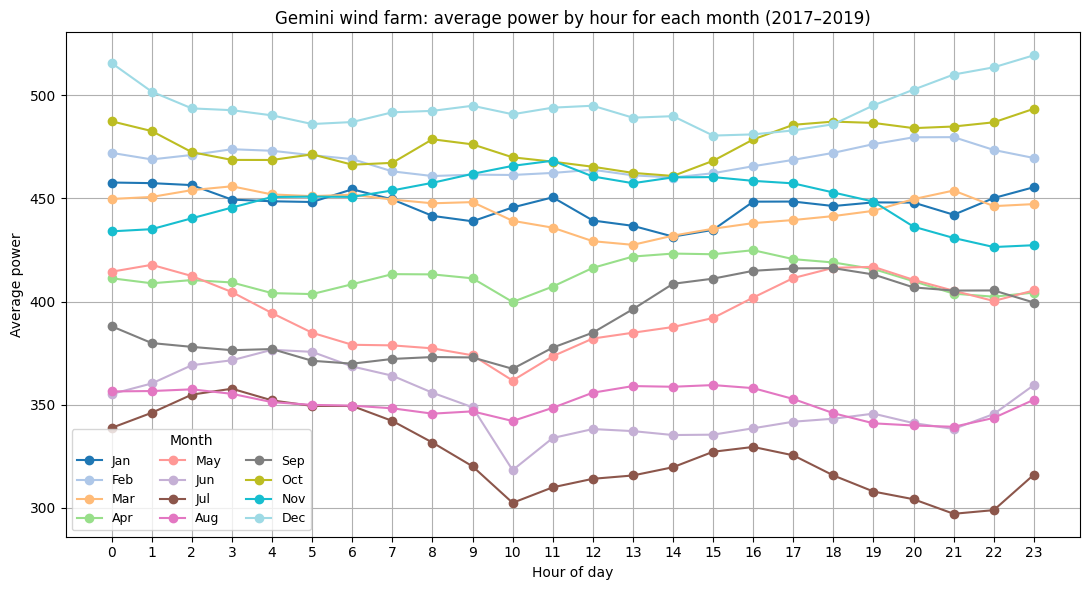

In [14]:
import pandas as pd
from pathlib import Path

# ====== INPUT ======
csv_path = Path("Gemini.csv")          # adjust if needed
ts_col = "time"
power_col = "Power"
start_year, end_year = 2017, 2019

# ====== LOAD ======
df = pd.read_csv(csv_path)
df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
df[power_col] = pd.to_numeric(df[power_col], errors="coerce")

df = df.dropna(subset=[ts_col, power_col])

# ====== FILTER 2017-2019 ======
df = df[(df[ts_col].dt.year >= start_year) & (df[ts_col].dt.year <= end_year)].copy()

# ====== EXTRACT MONTH + HOUR ======
df["month"] = df[ts_col].dt.month
df["hour"] = df[ts_col].dt.hour

# ====== AGGREGATE: avg power per month per hour ======
agg = (
    df.groupby(["month", "hour"], as_index=False)
      .agg(avg_power=(power_col, "mean"),
           n_obs=(power_col, "size"))
)

# Long format (288 rows)
agg_long = agg.sort_values(["month", "hour"]).reset_index(drop=True)

# Pivot format (12 x 24)
pivot = (
    agg_long.pivot(index="month", columns="hour", values="avg_power")
            .sort_index()
            .reindex(columns=list(range(24)))
            .reset_index()
            .rename(columns={"month": "month_num"})
)

# Optional: add month names
month_names = {i: pd.Timestamp(2000, i, 1).strftime("%b") for i in range(1, 13)}
pivot.insert(1, "month_name", pivot["month_num"].map(month_names))

# ====== SAVE ======
agg_long.to_csv("gemini_avg_power_month_hour_2017_2019_long.csv", index=False)
pivot.to_csv("gemini_avg_power_month_hour_2017_2019_pivot.csv", index=False)

print("Saved:",
      "gemini_avg_power_month_hour_2017_2019_long.csv",
      "gemini_avg_power_month_hour_2017_2019_pivot.csv")

# First 20 rows of the long table (month, hour, avg_power, n_obs)
print("\n=== First 20 rows: agg_long ===")
print(agg_long.head(20).to_string(index=False))

# First 20 rows of the pivot table (month x hour)
print("\n=== First 20 rows: pivot ===")
print(pivot.head(20).to_string(index=False))

# --- Plot: average power by hour for each month (12 lines) ---
month_names = {i: pd.Timestamp(2000, i, 1).strftime("%b") for i in range(1, 13)}

fig, ax = plt.subplots(figsize=(11, 6))

# 12 unique colours from a categorical colormap
cmap = plt.cm.get_cmap("tab20", 12)

for idx, m in enumerate(range(1, 13)):
    sub = agg_long.loc[agg_long["month"] == m, ["hour", "avg_power"]].sort_values("hour")
    if sub.empty:
        continue

    x = sub["hour"].to_numpy()
    y = sub["avg_power"].to_numpy(dtype=float)

    ax.plot(x, y, marker="o", linewidth=1.5, label=month_names[m], color=cmap(idx))

ax.set_xticks(range(24))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Average power")
ax.set_title("Gemini wind farm: average power by hour for each month (2017–2019)")
ax.grid(True)
ax.legend(title="Month", ncol=3, fontsize=9)
fig.tight_layout()
plt.show()